In [33]:
import jax.numpy as jnp
import jax
from scipy.optimize import root
import matplotlib.pyplot as plt
from jax import Array

AR1

In [34]:
rho = 0.9
def ar1(x_, x, eps):
    return rho*x_+eps-x

In [35]:
T = 50
xT = 0
Eps = jnp.zeros((T,1))
Eps = Eps.at[0].set(1)
X = jnp.zeros((T,1))
#X = X.at[0,:].set(0)

$$x_t = \rho x_{t-1}+\epsilon_t$$

In [36]:
def F(X, Eps):
    X = X.reshape(-1,1)
    out = jnp.zeros((T,1))
    for t in range(T):
        if t == 0:
            out = out.at[t].set(ar1(0, X[t,:], Eps[t,:]))
        else:
            out = out.at[t].set(ar1(X[t-1,:], X[t,:], Eps[t,:]))
    out
    return out

In [37]:
sol = root(lambda X: F(X,Eps).reshape(-1), x0=X)

In [39]:
X = sol.x
print(jnp.max(jnp.abs(F(X,Eps))))

0.0


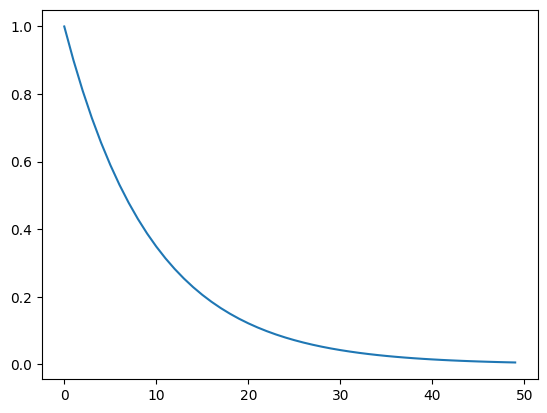

In [42]:
plt.plot(X)

VAR

$x_t=Ax_{t-1}+B\epsilon_t$



$X_t=\begin{bmatrix}x_0\\x_1\\ \vdots \\x_T\end{bmatrix}$

In [45]:
A = jnp.array([[0.8,0.2],
                [0.1,0.7]])
B = jnp.array([[1],[1]])
def var(x_, x, eps):
    '''
    x: 1d array
    eps: 1d array
    Returns
    -------
    1d array
    '''
    return A@x_+B@eps-x

In [46]:
T = 50
xT = 0
Eps = jnp.zeros((T,1))
Eps = Eps.at[0].set(1)
Eps = Eps.at[10].set(1)
X = jnp.zeros((T,2))
#X = X.at[0,:].set(0)

In [47]:
def F(X, Eps):
    X = X.reshape(-1,2)
    out = jnp.zeros((T,2))
    for t in range(T):
        if t == 0:
            out = out.at[t].set(var(jnp.array([0,0]), X[t,:], Eps[t,:]))
        else:
            out = out.at[t].set(var(X[t-1,:], X[t,:], Eps[t,:]))
    out
    return out

In [48]:
sol = root(lambda X: F(X,Eps).reshape(-1), x0=X.reshape(-1))

In [50]:
print(jnp.max(jnp.abs(F(sol.x,Eps))))

3.7252903e-09


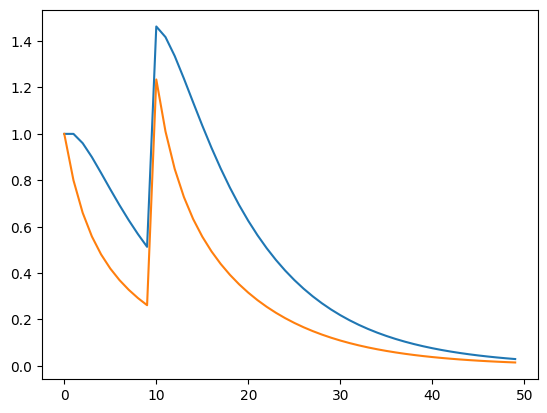

In [51]:
plt.plot(sol.x.reshape(-1,2))

NK model

$$\pi_t=\beta E[\pi_{t+1}]+\kappa y_{t}$$
$$y_t=E[y_{t+1}]+(1-\phi)E[\pi_{t+1}]+v_t$$
$$v_{t} = \rho_vv_{t-1}+\epsilon_{t}$$

In [30]:
phi = 1.2
kappa = 0.1
beta = 0.99
rho_v = 0.5

def f(x_:Array, x:Array, p:Array, p1:Array, eps:Array)->Array:
    v_ = x_[0]
    v =  x[0] 
    y, pi = p
    y1, pi1 = p1
    out = jnp.zeros(3)
    out = out.at[0].set(beta*pi1+kappa*y-pi)
    out = out.at[1].set(y1+(1-phi)*pi1+v-y)
    out = out.at[2].set(rho_v*v_+eps[0]-v)
    return out

def F(X, P, Eps):
    out = jnp.zeros((T,3))
    for t in range(T):
        if t == 0:
            out = out.at[t].set(f(jnp.array([0]), X[t,:], P[t,:],P[t+1,:], Eps[t,:]))
        if t== T-1:
            out = out.at[t].set(f(X[t-1,:], X[t,:], P[t,:],jnp.array([0,0]), Eps[t,:]))
        else:
            out = out.at[t].set(f(X[t-1,:], X[t,:], P[t,:],P[t+1,:], Eps[t,:]))
    out
    return out

In [31]:
def broadcast(x:Array, Eps):
    x = x.reshape((T,-1))
    X = x[:,[1]]
    P = x[:,[1,2]]
    return F(X,P,Eps)

In [32]:
T = 50
xT = 0
Eps = jnp.zeros((T,1))
Eps = Eps.at[0].set(1)
X = jnp.zeros((T,1))
P = jnp.zeros((T,2))

sol = root(lambda x: broadcast(x,Eps).flatten(), x0=jnp.column_stack((X,P)).flatten())

In [191]:
sol

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 1.965e-03  1.827e-01 ...  0.000e+00  2.355e-02]
       x: [-1.318e+20  8.880e-01 ... -2.735e-02 -8.350e-03]
    nfev: 409
    fjac: [[ 1.000e+00  2.565e-07 ...  0.000e+00  2.483e-07]
           [ 1.000e-05  2.294e-08 ...  0.000e+00  2.221e-08]
           ...
           [ 0.000e+00 -4.767e-04 ...  0.000e+00 -1.095e-03]
           [ 0.000e+00 -0.000e+00 ...  1.000e+00 -0.000e+00]]
       r: [ 1.742e-23  1.000e-01 ... -6.101e-03 -0.000e+00]
     qtf: [ 1.964e-03  6.487e-04 ... -9.256e-05 -0.000e+00]

In [192]:
x = sol.x

In [193]:
x = x.reshape((T,-1))
X = x[:,[1]]
P = x[:,[1,2]]

In [194]:
F(X,P,Eps)

Array([[ 1.96512416e-03,  1.82719380e-01,  9.82778072e-02],
       [-3.02041229e-02,  3.66482250e-02,  1.95104823e-01],
       [-3.75562124e-02,  4.22974071e-03,  3.20733637e-02],
       [-3.18621397e-02, -3.55265290e-03, -4.88415360e-03],
       [-3.12328525e-02, -3.75477527e-03, -1.07607935e-02],
       [-2.44064312e-02, -4.12326679e-03, -1.13071520e-02],
       [-2.38401275e-02, -2.83314940e-03, -9.16973315e-03],
       [-1.78701188e-02, -2.93548196e-03, -8.22326634e-03],
       [-1.76702011e-02, -1.82637072e-03, -6.19857572e-03],
       [-1.26890857e-02, -1.98816438e-03, -5.54690696e-03],
       [-1.27393948e-02, -1.12158619e-03, -3.99956806e-03],
       [-8.73316731e-03, -1.31645123e-03, -3.62561317e-03],
       [-8.91838036e-03, -6.59975049e-04, -2.48465594e-03],
       [-5.81404520e-03, -8.48639058e-04, -2.30154512e-03],
       [-6.05151523e-03, -3.69609828e-04, -1.48770446e-03],
       [-3.73799191e-03, -5.33377344e-04, -1.41602615e-03],
       [-3.97374481e-03, -1.95050598e-04

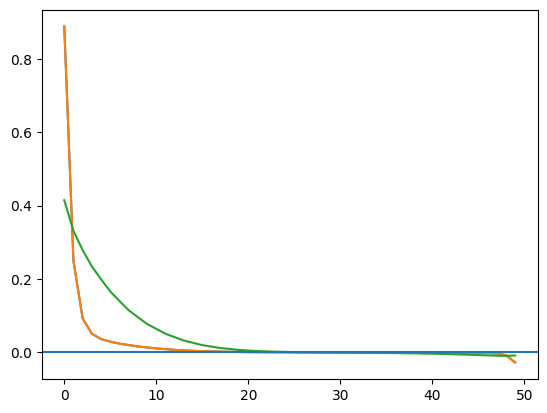

In [195]:
fig,ax=plt.subplots()
ax.plot(X)
ax.plot(P)
ax.axhline(0)